# Assignment 4 - Task 1 - Dimensionality Reduction

## Table of Contents:
1. Introduction and Methodology
2. MNIST Development Class
3. Load and Explore Data
4. Apply PCA
5. Apply t-SNE
6. Apply Autoencoder 1
7. Apply Autoencoder 2
8. Representation Quality
9. Technique Comparison
10. Representation
11. Conclusion

## Introduction and Methodology:


In this notebook we will apply various dimensionality reduction techniques to the MNIST dataset. We will download the dataset via torch, visualize the data to get a sense of what the data and its assoicated labels look like, then apply various algorithms to reduce and visualize it. The dataset consists of images of handwritten digits randing from 0-9. Each image is 28x28. The objective of these techniques is to project the high dimensional data into a 2d space to see the separability. First we will explore PCA or Principal Component Analysis. This is a linear method that will project the data into a subspace defined by the direction of maximum variance. Next we will apply t-SNE, or t-Dsitributed Stochastic Neighbor Embedding, a non linear method that minimizes the divergence between high-dim and low-dim data distribution. FInally, we will explore an AutoEncoder, a Neural network method that compresses data into a bottleneck known as the latent space.





In [1]:
# I needed to disable ssl to download the dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [79]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

## MNIST Class:

In [45]:
class MNISTDimensionalityReduction:
    """
    A class to manage the analysis of the dataset
    """
    def __init__(self):
        self.data = None
        self.labels = None
        self.normalized_data = None
        self.reduced_data = {}
        self.autoencoder = None
        self.encoder_model = None

    def load_data(self):
        """
        Load MNIST dataset via transforms
        """
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        
        dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

        # convert to numpy arrays
        self.data = dataset.data.numpy().reshape(len(dataset), -1).astype('float32')
        self.labels = dataset.targets.numpy()
        
        # Basic dataset statistics
        print(f"Data shape: {self.data.shape}")
        print(f"Label shape: {self.labels.shape}")
        print("Data stats:")
        print(pd.DataFrame(self.data).describe())
        print(f"Unique labels: {np.unique(self.labels)}")

    def explore_data(self, sample_size=5):
        """
        visualize some random samples
        """
        print(f"Exploring {sample_size} random samples from the dataset.")
        
        # create the fig
        fig, axes = plt.subplots(1, sample_size, figsize=(10, 2))
        
        # iterate of the samples
        for i in range(sample_size):
            idx = np.random.randint(0, len(self.data))
            axes[i].imshow(self.data[idx].reshape(28, 28), cmap='gray')
            axes[i].set_title(f"Label: {self.labels[idx]}")
            axes[i].axis('off')
        plt.show()

    def normalize_data(self):
        """
        normalize the data to a range of 0-1 using SS
        """
        scaler = StandardScaler()
        self.normalized_data = scaler.fit_transform(self.data)
        print("Data normalized")
        print("Normalized data stats:")
        # print(pd.DataFrame(self.normalized_data).describe())
        print(pd.DataFrame(self.normalized_data).describe())

    def apply_pca(self, n_components=2):
        """
        apply pca model
        """
        # print(f"Applying PCA model..")
        print(f"Applying PCA with {n_components} components...")
        
        # create model
        pca = PCA(n_components=n_components)
        
        # udpate the reduce data and visualise
        self.reduced_data['PCA'] = pca.fit_transform(self.normalized_data)
        self.visualize_result('PCA')

    def apply_tsne(self, n_components=2, perplexity=30, n_iter=1000):
        """
        apple t-SNE
        """
        print(f"Applying t-SNE with perplexity={perplexity}, n_iter={n_iter}...")
        
        # create the model
        tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter)
        
        # update the RD attribute
        self.reduced_data['t-SNE'] = tsne.fit_transform(self.normalized_data)
        self.visualize_result('t-SNE')

    def train_autoencoder(self, encoding_dim=2, epochs=10, batch_size=256):
        """
        apply the AE model
        """
        print(f"Training Autoencoder with encoding dimension={encoding_dim}, epochs={epochs}, batch_size={batch_size}...")
        
        # set input
        input_dim = self.normalized_data.shape[1]
        input_layer = Input(shape=(input_dim,))
        
        # set the encoder and decoder
        encoded = Dense(encoding_dim, activation='relu')(input_layer)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)

        # update attributes
        self.autoencoder = Model(input_layer, decoded)
        self.autoencoder.compile(optimizer=Adam(), loss='mse')

        # create model
        self.encoder_model = Model(input_layer, encoded)

        # fit
        self.autoencoder.fit(self.normalized_data, self.normalized_data,
                             epochs=epochs, batch_size=batch_size, verbose=1)
        print("Autoencoder trained.")

    def apply_autoencoder(self):
        """
        Apply AE model
        """
        # print(f"AE: {self.encoder_model}")
        if self.encoder_model is not None:
            print("Applying Autoencoder for dimensionality reduction...")
            self.reduced_data['Autoencoder'] = self.encoder_model.predict(self.normalized_data)
            self.visualize_result('Autoencoder')
        else:
            print("Error! check AE model")

    def visualize_result(self, method):
        """
        visualize 2D scatter plot based on method to keep them consistent
        """
        if method in self.reduced_data:
            # get data from class
            data = self.reduced_data[method]
            
            # create plot
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(data[:, 0], data[:, 1], c=self.labels, cmap='tab10', s=1, alpha=0.7)
            plt.colorbar(scatter, ticks=range(10), label='Digit Label')
            plt.title(f"2D Visualization using {method}")
            plt.xlabel("Dimension 1")
            plt.ylabel("Dimension 2")
            plt.show()
        else:
            print(f"Error! check method.")


In [46]:
# Instantiate the class
mnist_reduction = MNISTDimensionalityReduction()

### Load and Explore Data:

In [47]:
# load the data
mnist_reduction.load_data()

Data shape: (60000, 784)
Label shape: (60000,)
Data stats:
           0        1        2        3        4        5        6        7    \
count  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           8        9    ...           774           775           776  \
count  60000.0  60000.0  ...  60000.000000  60000.000000  60000.000000   
mean       0.0      0.0  ...      0.200433      0.088867      0

Exploring 5 random samples from the dataset.


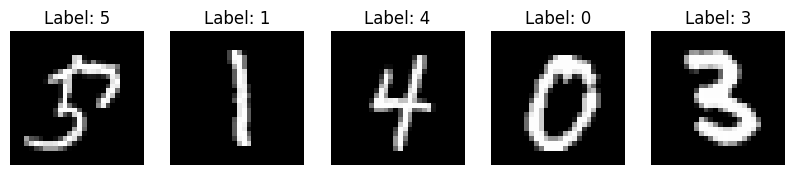

In [48]:
# explore the data with random samples
mnist_reduction.explore_data()

Exploring 5 random samples from the dataset.


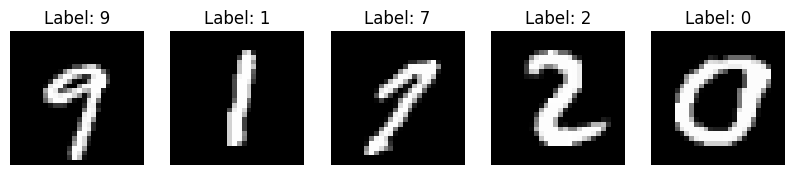

In [49]:
mnist_reduction.explore_data()

Exploring 5 random samples from the dataset.


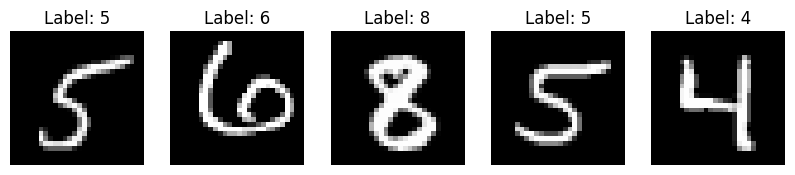

In [50]:
mnist_reduction.explore_data()

In [51]:
mnist_reduction.normalize_data()

Data normalized.
Normalized data stats:
           0        1        2        3        4        5        6        7    \
count  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           8        9    ...           774           775           776  \
count  60000.0  60000.0  ...  6.000000e+04  6.000000e+04  6.000000e+04   
mean       0.0      0.0  ... -5.404154e-09  1.716614e-09  1.955032e-09   
std     

Exploring 5 random samples from the dataset.


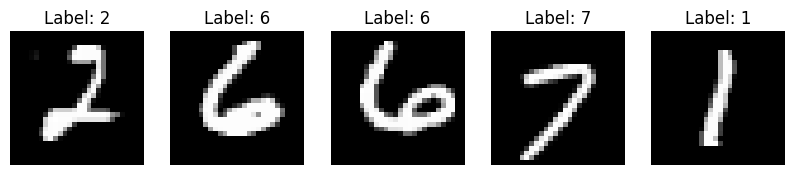

In [52]:
mnist_reduction.explore_data()

Exploring 5 random samples from the dataset.


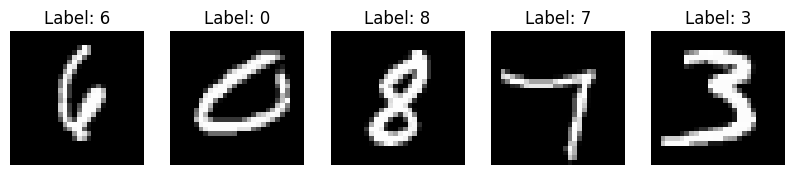

In [53]:
mnist_reduction.explore_data()

Exploring 5 random samples from the dataset.


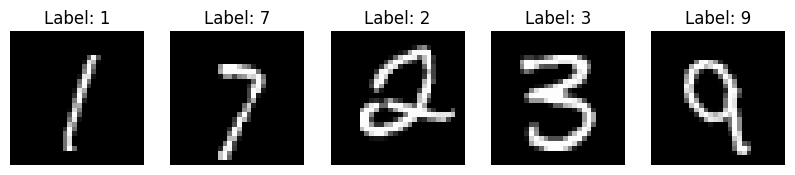

In [54]:
mnist_reduction.explore_data()

### Apply PCA:

Applying PCA with 2 components...


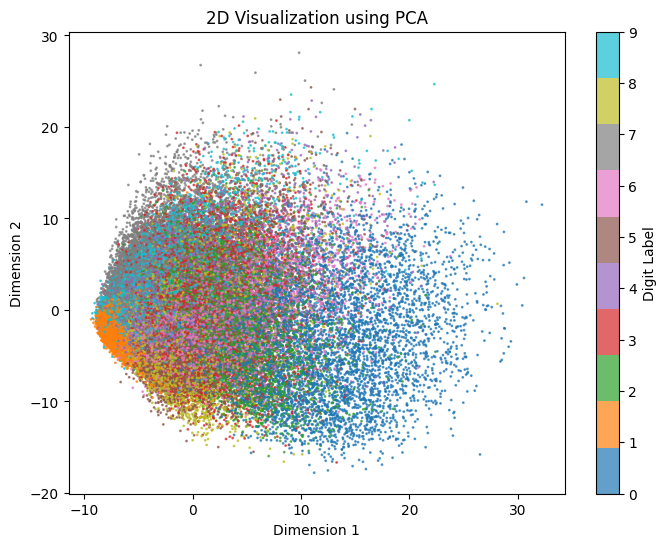

In [55]:
mnist_reduction.apply_pca(n_components=2)

Applying PCA with 3 components...


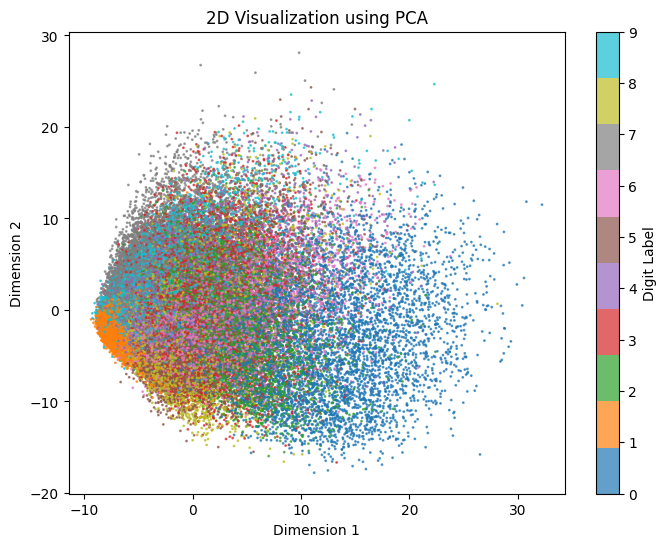

In [56]:
mnist_reduction.apply_pca(n_components=3)

Applying PCA with 4 components...


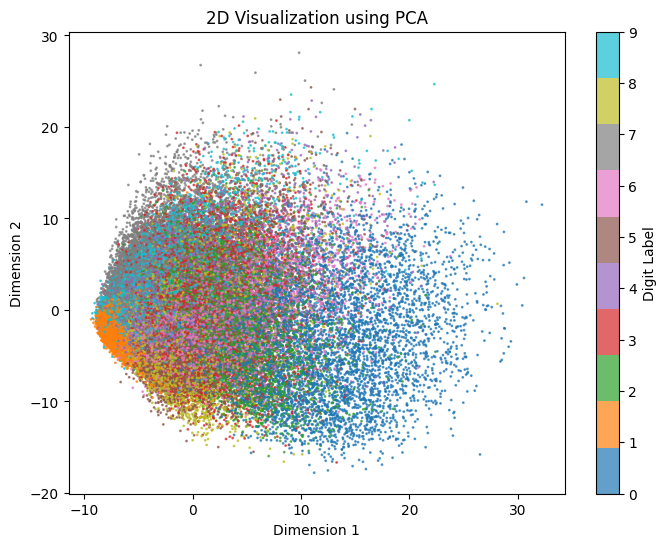

In [57]:
mnist_reduction.apply_pca(n_components=4)

### Apply TSNE:

Applying t-SNE with perplexity=40, n_iter=1000...


/Users/alkhalifas/Documents/Github/cs6140-machine-learning/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


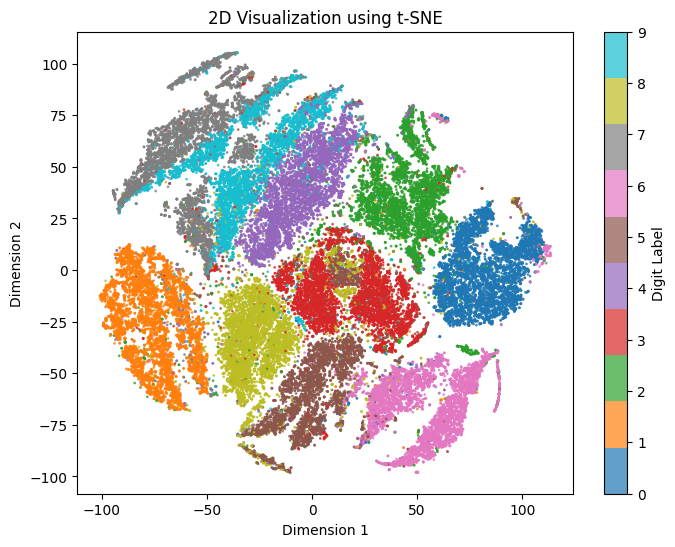

In [58]:
mnist_reduction.apply_tsne(perplexity=40, n_iter=1000)

Applying t-SNE with perplexity=20, n_iter=1000...


/Users/alkhalifas/Documents/Github/cs6140-machine-learning/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


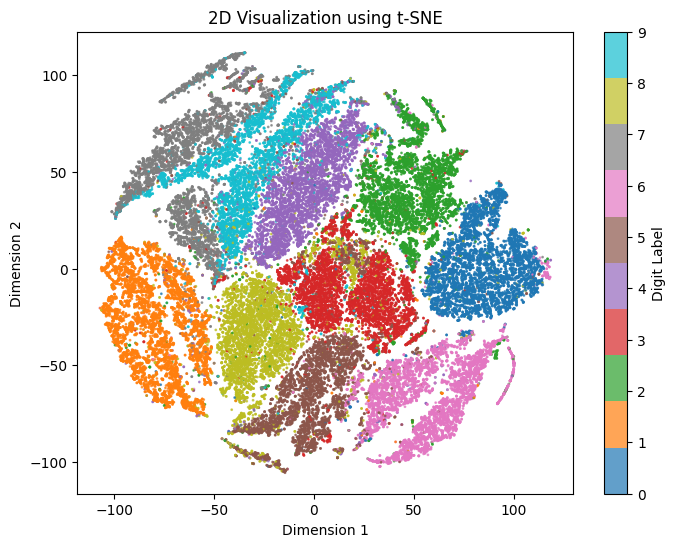

In [59]:
mnist_reduction.apply_tsne(perplexity=20, n_iter=1000)


Applying t-SNE with perplexity=10, n_iter=1000...


/Users/alkhalifas/Documents/Github/cs6140-machine-learning/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


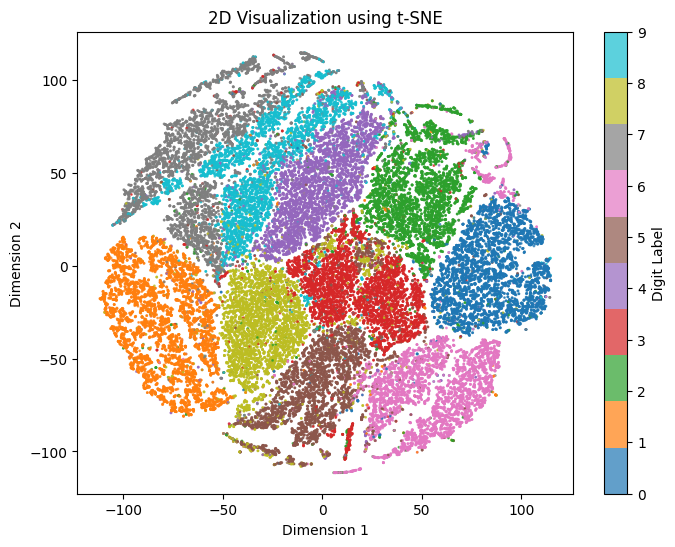

In [60]:
mnist_reduction.apply_tsne(perplexity=10, n_iter=1000)


Applying t-SNE with perplexity=5, n_iter=1000...


/Users/alkhalifas/Documents/Github/cs6140-machine-learning/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


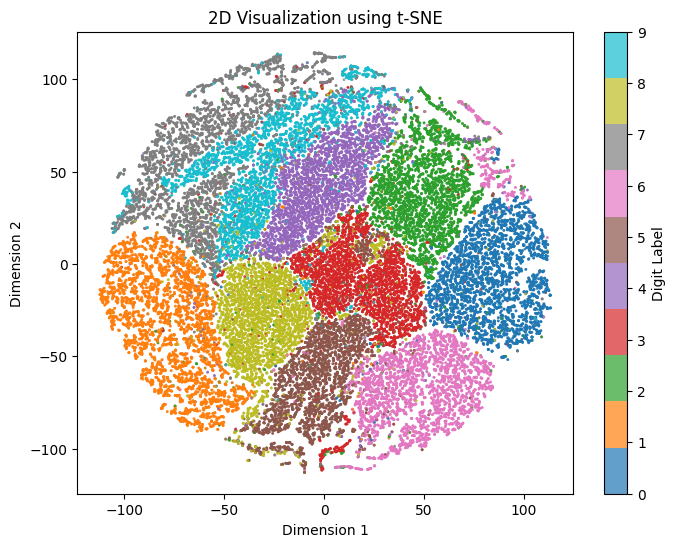

In [61]:
mnist_reduction.apply_tsne(perplexity=5, n_iter=1000)


Applying t-SNE with perplexity=5, n_iter=500...


/Users/alkhalifas/Documents/Github/cs6140-machine-learning/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


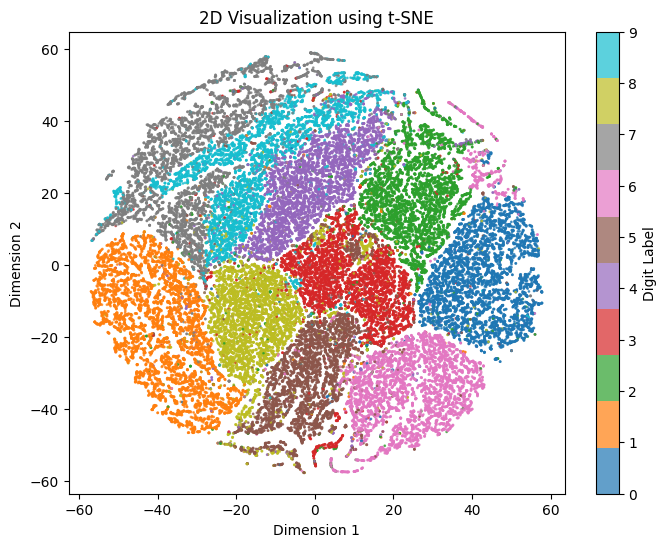

In [62]:
mnist_reduction.apply_tsne(perplexity=5, n_iter=500)


Applying t-SNE with perplexity=5, n_iter=250...


/Users/alkhalifas/Documents/Github/cs6140-machine-learning/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


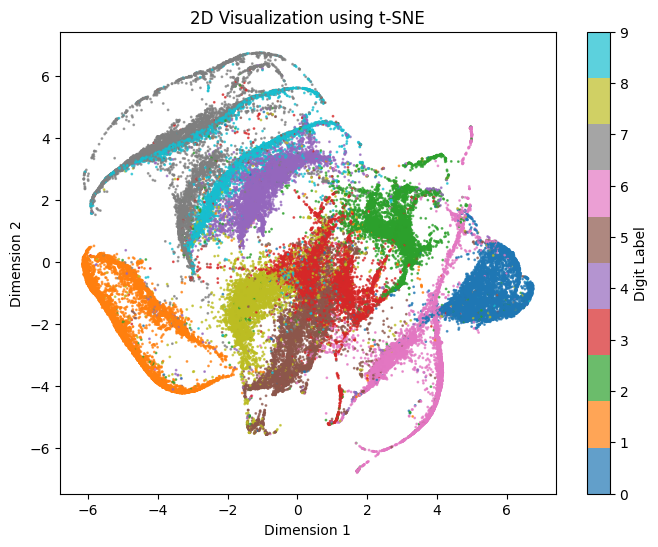

In [63]:
mnist_reduction.apply_tsne(perplexity=5, n_iter=250)


### Apply AutoEncoders:

### Applied first AE from class above:

Training Autoencoder with encoding dimension=2, epochs=5, batch_size=256...
Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0907
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9317
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9001
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8888
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8922
Autoencoder trained.
Applying Autoencoder for dimensionality reduction...
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


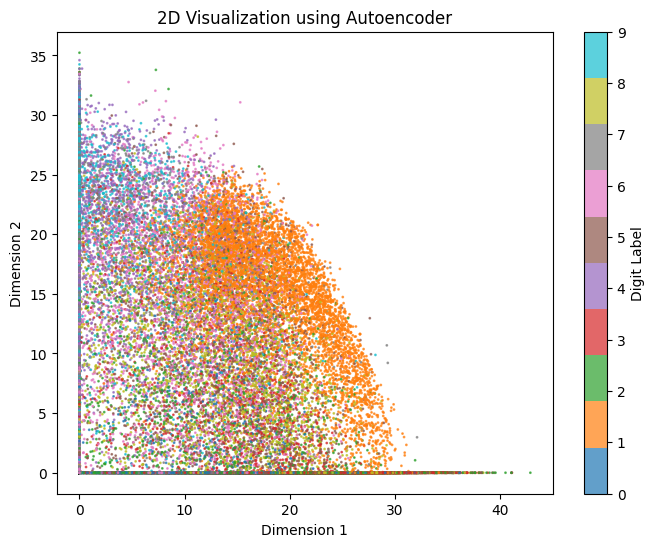

In [71]:
mnist_reduction.train_autoencoder(encoding_dim=2, epochs=5, batch_size=256)
mnist_reduction.apply_autoencoder()

Training Autoencoder with encoding dimension=10, epochs=5, batch_size=256...
Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9970
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7919
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7932
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7634
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7485
Autoencoder trained.
Applying Autoencoder for dimensionality reduction...
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 795us/step


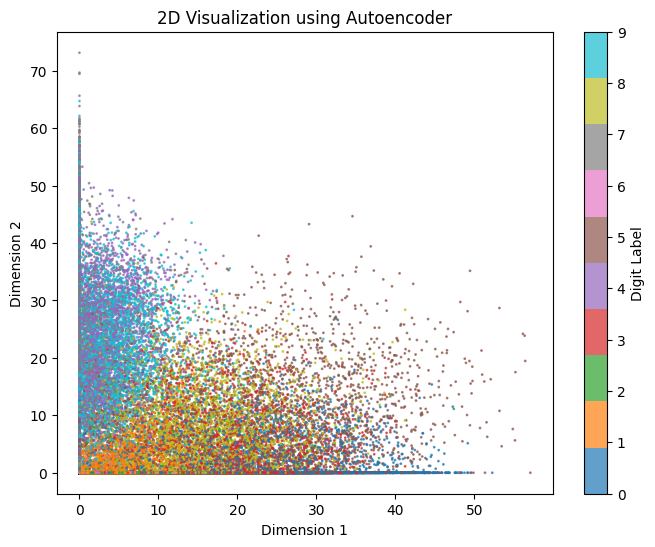

In [73]:
mnist_reduction.train_autoencoder(encoding_dim=10, epochs=5, batch_size=256)
mnist_reduction.apply_autoencoder()

Training Autoencoder with encoding dimension=5, epochs=10, batch_size=256...
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0423
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8485
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8153
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8158
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8030
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7987
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7982
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8020
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8240
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7987
Autoencoder trained.
Applying Autoencoder for dimensionality reduction...
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step


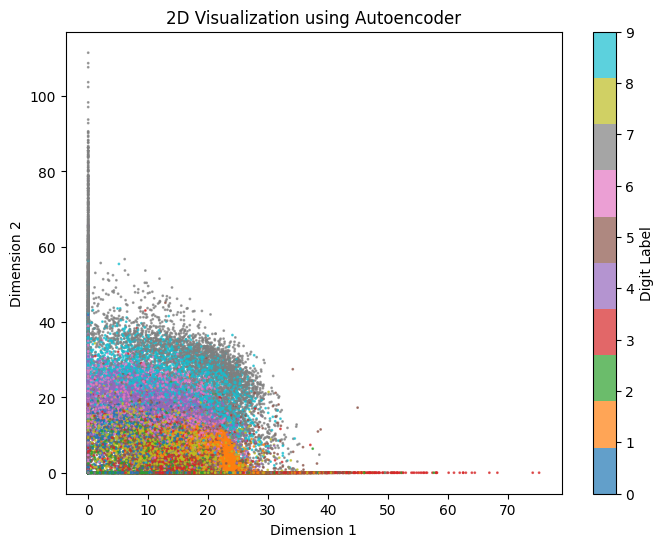

In [75]:
mnist_reduction.train_autoencoder(encoding_dim=5, epochs=10, batch_size=256)
mnist_reduction.apply_autoencoder()

Training Autoencoder with encoding dimension=5, epochs=10, batch_size=126...
Epoch 1/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9626
Epoch 2/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.8363
Epoch 3/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.7990
Epoch 4/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 0.8425
Epoch 5/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.7958
Epoch 6/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8213
Epoch 7/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7917
Epoch 8/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 0.7887
Epoch 9/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 0.7906
Epoch 10/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 0.7730
Autoencoder trained.
Applying Autoencoder for dimensionality reduction...
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step


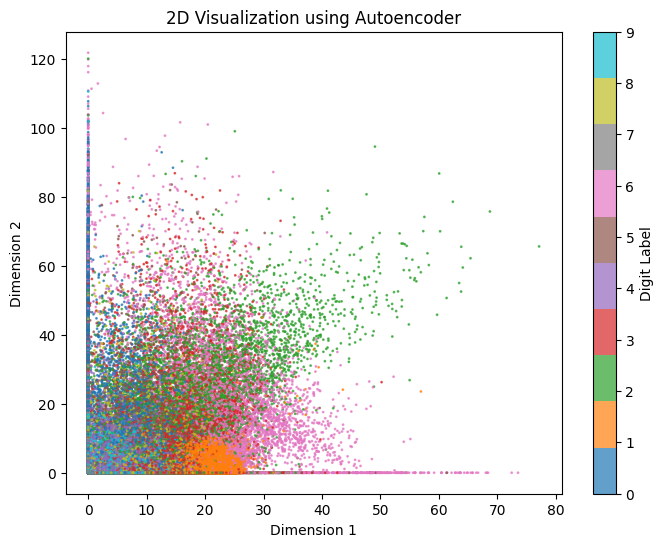

In [77]:
mnist_reduction.train_autoencoder(encoding_dim=5, epochs=10, batch_size=126)
mnist_reduction.apply_autoencoder()

Training Autoencoder with encoding dimension=5, epochs=10, batch_size=64...
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 578us/step - loss: 0.9317
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 0.8074
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - loss: 0.8211
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - loss: 0.8007
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 0.7892
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 527us/step - loss: 0.7731
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/step - loss: 0.7921
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 0.8084
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step - loss: 0.7802
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - loss: 0.8116
Autoencoder trained.
Applying Autoencoder for dimensionality reduction...
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step


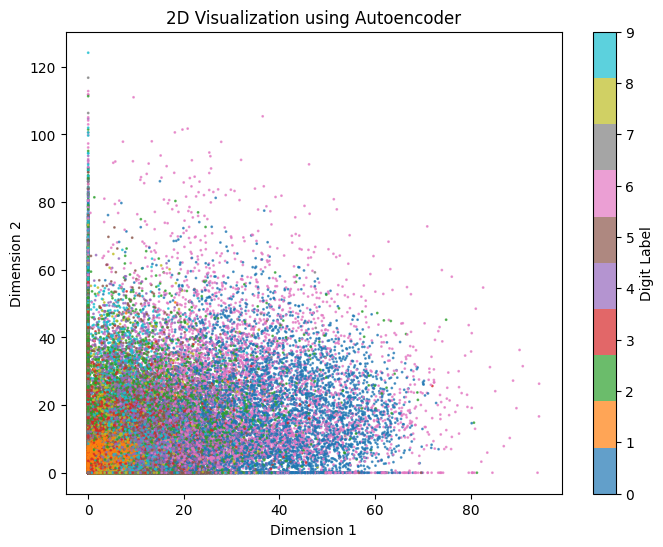

In [78]:
mnist_reduction.train_autoencoder(encoding_dim=5, epochs=10, batch_size=64)
mnist_reduction.apply_autoencoder()

### Applied second AE based on Professors Implementation:

In [80]:
class Autoencoder(nn.Module):
    """
    AE Implementation based on professors lecture
    """
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        # Create the encoder params
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim),
        )
        # Create the decoder params
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        """
        forward pass of model
        """
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class AutoencoderExperiment:
    """
    AE experiment to test multiple architectures
    """
    def __init__(self, encoding_dim=2, batch_size=128, learning_rate=0.001, num_epochs=10):
        self.encoding_dim = encoding_dim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = Autoencoder(encoding_dim).to(self.device)
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.train_loader = None
        self.test_loader = None

    def load_data(self):
        """
        load dataset
        """
        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=self.transform)
        test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=self.transform)
        # test_dataset = datasets.MNIST(root='./data', train=False, download=False, transform=self.transform)
        # test_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=self.transform)
        self.train_loader = DataLoader(dataset=train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)
        print(f"Data loaded: Train set size={len(train_dataset)}, Test set size={len(test_dataset)}")

    def train_autoencoder(self):
        """
        Train the autoencoder
        """
        
        # Set criterion and opt
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.model.train()

        print("Training autoencoder...")
        # print("Loss: ", criterion(self.model(self.train_loader), self))
        
        # Iterate of the epochs
        for epoch in range(self.num_epochs):
            # Over inputs
            for inputs, _ in self.train_loader:
                inputs = inputs.to(self.device).view(inputs.size(0), -1)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                # print("outputs: ", outputs)
                loss = criterion(outputs, inputs)
                loss.backward()
                optimizer.step()

            print(f"Epoch {epoch + 1}/{self.num_epochs}, Loss: {loss.item():.4f}")

        print("Training complete.")

    def visualize_bottleneck(self):
        """
        Visualize the bottleneck
        """
        # print("Visualizing bottleneck layer...")
        self.model.eval()
        
        # space for embeddings and labels
        all_embeddings = []
        all_labels = []

        # process
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs = inputs.to(self.device).view(inputs.size(0), -1)
                embeddings = self.model.encoder(inputs).cpu().numpy()
                all_embeddings.append(embeddings)
                all_labels.append(labels.numpy())

        # get all embeddings and labels
        all_embeddings = np.concatenate(all_embeddings, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        # plot results
        plt.figure(figsize=(10, 8))
        for digit in range(10):
            digit_indices = all_labels == digit
            plt.scatter(all_embeddings[digit_indices, 0], all_embeddings[digit_indices, 1], label=str(digit), alpha=0.7)
        plt.title("Bottleneck Layer Visualization")
        plt.xlabel("Bottleneck Dimension 1")
        plt.ylabel("Bottleneck Dimension 2")
        plt.legend()
        plt.show()

    def adjust_hyperparameters(self, encoding_dim=None, batch_size=None, learning_rate=None, num_epochs=None):
        """
        adjust hyperparameters - todo: remove and add in method above
        """
        if encoding_dim is not None:
            self.encoding_dim = encoding_dim
            self.model = Autoencoder(encoding_dim).to(self.device)
        if batch_size is not None:
            self.batch_size = batch_size
        if learning_rate is not None:
            self.learning_rate = learning_rate
        if num_epochs is not None:
            self.num_epochs = num_epochs
        print("Hyperparameters updated.")

Data loaded: Train set size=60000, Test set size=10000
Training autoencoder...
Epoch 1/10, Loss: 0.0475
Epoch 2/10, Loss: 0.0404
Epoch 3/10, Loss: 0.0379
Epoch 4/10, Loss: 0.0414
Epoch 5/10, Loss: 0.0356
Epoch 6/10, Loss: 0.0401
Epoch 7/10, Loss: 0.0369
Epoch 8/10, Loss: 0.0363
Epoch 9/10, Loss: 0.0354
Epoch 10/10, Loss: 0.0338
Training complete.
Visualizing bottleneck layer...


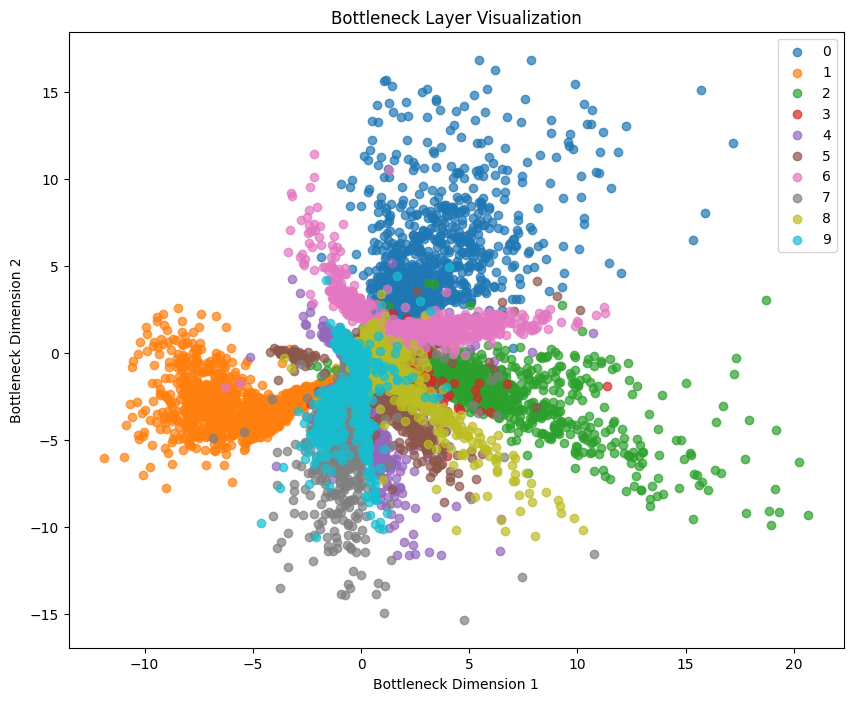

In [89]:
experiment = AutoencoderExperiment(encoding_dim=2, batch_size=128, learning_rate=0.001, num_epochs=10)
experiment.load_data()
experiment.train_autoencoder()
experiment.visualize_bottleneck()

Data loaded: Train set size=60000, Test set size=10000
Training autoencoder...
Epoch 1/10, Loss: 0.0396
Epoch 2/10, Loss: 0.0347
Epoch 3/10, Loss: 0.0325
Epoch 4/10, Loss: 0.0313
Epoch 5/10, Loss: 0.0310
Epoch 6/10, Loss: 0.0330
Epoch 7/10, Loss: 0.0316
Epoch 8/10, Loss: 0.0303
Epoch 9/10, Loss: 0.0302
Epoch 10/10, Loss: 0.0300
Training complete.
Visualizing bottleneck layer...


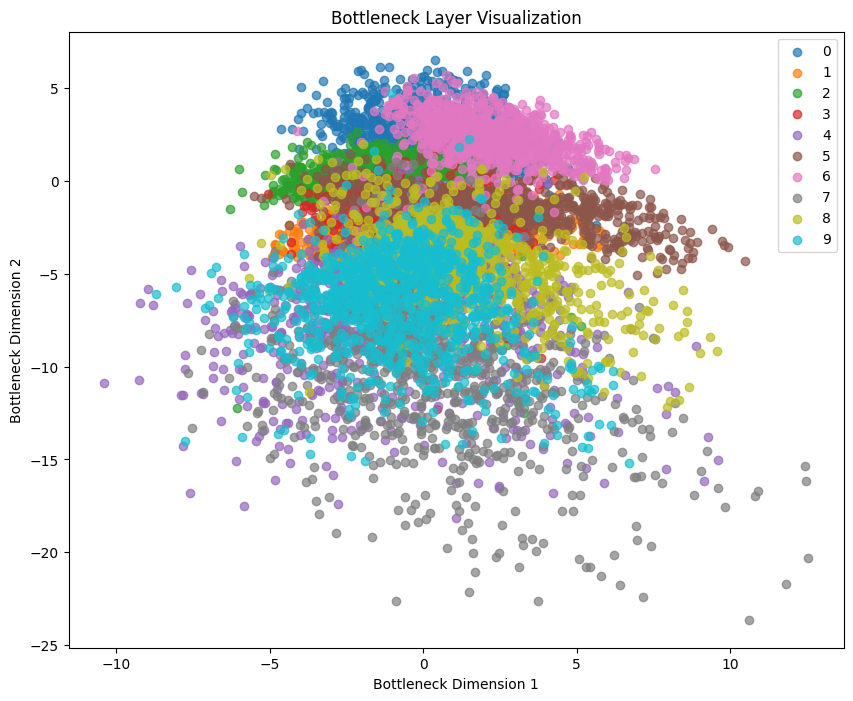

In [86]:
experiment = AutoencoderExperiment(encoding_dim=3, batch_size=128, learning_rate=0.001, num_epochs=10)
experiment.load_data()
experiment.train_autoencoder()
experiment.visualize_bottleneck()

Data loaded: Train set size=60000, Test set size=10000
Training autoencoder...
Epoch 1/10, Loss: 0.0312
Epoch 2/10, Loss: 0.0310
Epoch 3/10, Loss: 0.0321
Epoch 4/10, Loss: 0.0279
Epoch 5/10, Loss: 0.0247
Epoch 6/10, Loss: 0.0273
Epoch 7/10, Loss: 0.0267
Epoch 8/10, Loss: 0.0279
Epoch 9/10, Loss: 0.0258
Epoch 10/10, Loss: 0.0272
Training complete.
Visualizing bottleneck layer...


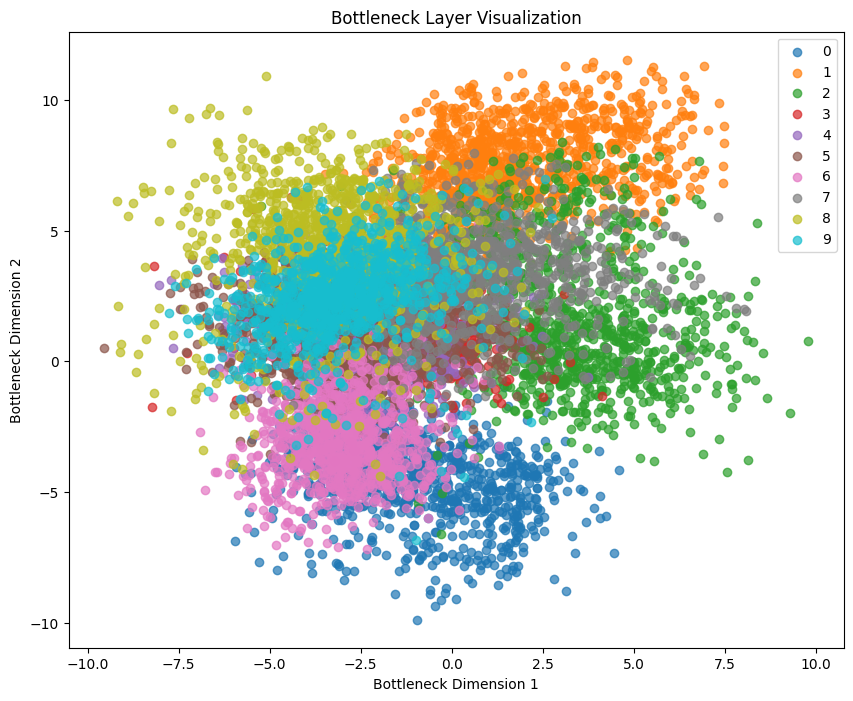

In [87]:
experiment = AutoencoderExperiment(encoding_dim=4, batch_size=128, learning_rate=0.001, num_epochs=10)
experiment.load_data()
experiment.train_autoencoder()
experiment.visualize_bottleneck()

Data loaded: Train set size=60000, Test set size=10000
Training autoencoder...
Epoch 1/10, Loss: 0.0289
Epoch 2/10, Loss: 0.0282
Epoch 3/10, Loss: 0.0270
Epoch 4/10, Loss: 0.0236
Epoch 5/10, Loss: 0.0247
Epoch 6/10, Loss: 0.0255
Epoch 7/10, Loss: 0.0250
Epoch 8/10, Loss: 0.0241
Epoch 9/10, Loss: 0.0222
Epoch 10/10, Loss: 0.0220
Training complete.
Visualizing bottleneck layer...


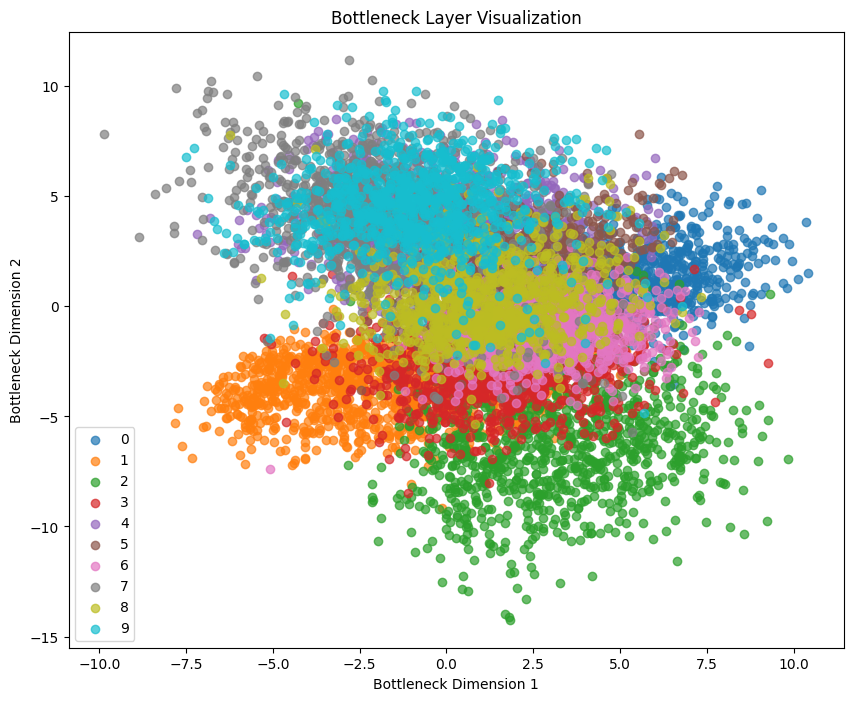

In [88]:
experiment = AutoencoderExperiment(encoding_dim=5, batch_size=128, learning_rate=0.001, num_epochs=10)
experiment.load_data()
experiment.train_autoencoder()
experiment.visualize_bottleneck()

Data loaded: Train set size=60000, Test set size=10000
Training autoencoder...
Epoch 1/10, Loss: 0.0452
Epoch 2/10, Loss: 0.0431
Epoch 3/10, Loss: 0.0384
Epoch 4/10, Loss: 0.0365
Epoch 5/10, Loss: 0.0387
Epoch 6/10, Loss: 0.0393
Epoch 7/10, Loss: 0.0396
Epoch 8/10, Loss: 0.0364
Epoch 9/10, Loss: 0.0354
Epoch 10/10, Loss: 0.0353
Training complete.
Visualizing bottleneck layer...


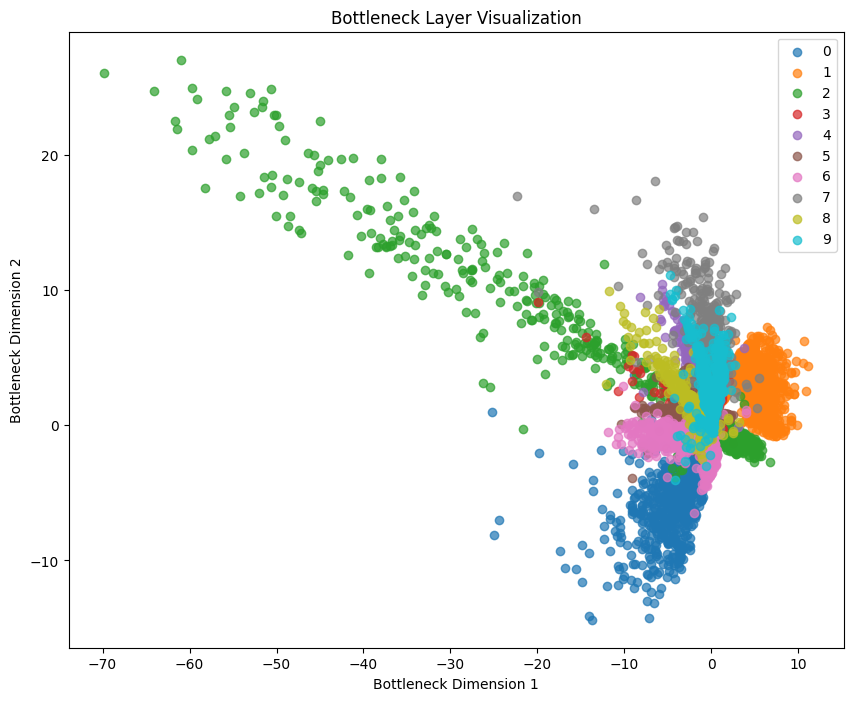

In [91]:
experiment = AutoencoderExperiment(encoding_dim=2, batch_size=128, learning_rate=0.001, num_epochs=10)
experiment.load_data()
experiment.train_autoencoder()
experiment.visualize_bottleneck()

Data loaded: Train set size=60000, Test set size=10000
Training autoencoder...
Epoch 1/20, Loss: 0.0464
Epoch 2/20, Loss: 0.0391
Epoch 3/20, Loss: 0.0409
Epoch 4/20, Loss: 0.0402
Epoch 5/20, Loss: 0.0395
Epoch 6/20, Loss: 0.0403
Epoch 7/20, Loss: 0.0374
Epoch 8/20, Loss: 0.0346
Epoch 9/20, Loss: 0.0366
Epoch 10/20, Loss: 0.0386
Epoch 11/20, Loss: 0.0392
Epoch 12/20, Loss: 0.0388
Epoch 13/20, Loss: 0.0330
Epoch 14/20, Loss: 0.0350
Epoch 15/20, Loss: 0.0344
Epoch 16/20, Loss: 0.0349
Epoch 17/20, Loss: 0.0361
Epoch 18/20, Loss: 0.0338
Epoch 19/20, Loss: 0.0333
Epoch 20/20, Loss: 0.0333
Training complete.
Visualizing bottleneck layer...


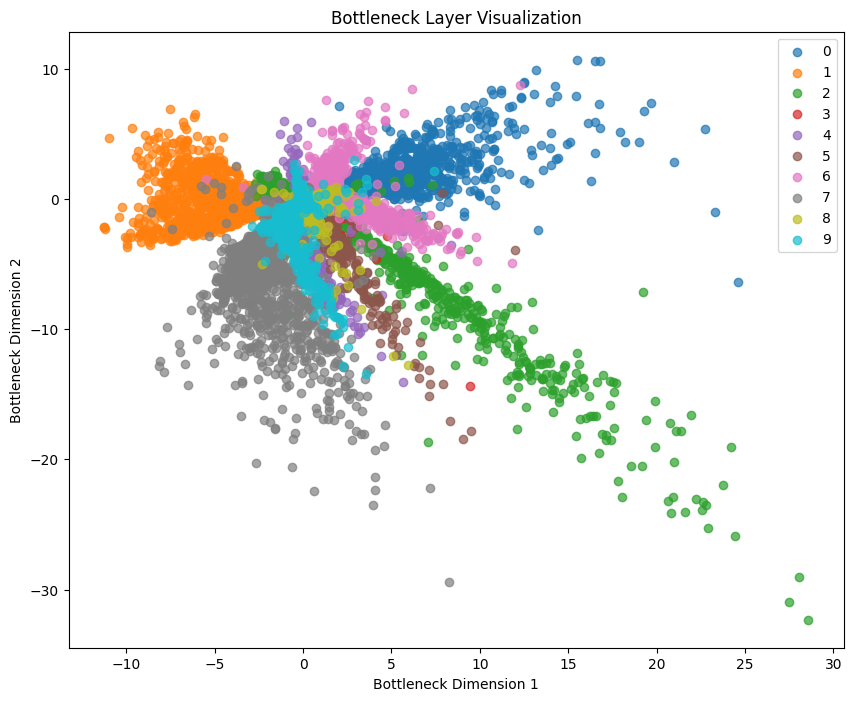

In [90]:
experiment = AutoencoderExperiment(encoding_dim=2, batch_size=128, learning_rate=0.001, num_epochs=20)
experiment.load_data()
experiment.train_autoencoder()
experiment.visualize_bottleneck()

Data loaded: Train set size=60000, Test set size=10000
Training autoencoder...
Epoch 1/30, Loss: 0.0443
Epoch 2/30, Loss: 0.0428
Epoch 3/30, Loss: 0.0425
Epoch 4/30, Loss: 0.0421
Epoch 5/30, Loss: 0.0431
Epoch 6/30, Loss: 0.0370
Epoch 7/30, Loss: 0.0412
Epoch 8/30, Loss: 0.0362
Epoch 9/30, Loss: 0.0367
Epoch 10/30, Loss: 0.0378
Epoch 11/30, Loss: 0.0403
Epoch 12/30, Loss: 0.0364
Epoch 13/30, Loss: 0.0371
Epoch 14/30, Loss: 0.0375
Epoch 15/30, Loss: 0.0371
Epoch 16/30, Loss: 0.0334
Epoch 17/30, Loss: 0.0363
Epoch 18/30, Loss: 0.0365
Epoch 19/30, Loss: 0.0367
Epoch 20/30, Loss: 0.0382
Epoch 21/30, Loss: 0.0345
Epoch 22/30, Loss: 0.0348
Epoch 23/30, Loss: 0.0320
Epoch 24/30, Loss: 0.0344
Epoch 25/30, Loss: 0.0362
Epoch 26/30, Loss: 0.0356
Epoch 27/30, Loss: 0.0332
Epoch 28/30, Loss: 0.0389
Epoch 29/30, Loss: 0.0362
Epoch 30/30, Loss: 0.0324
Training complete.
Visualizing bottleneck layer...


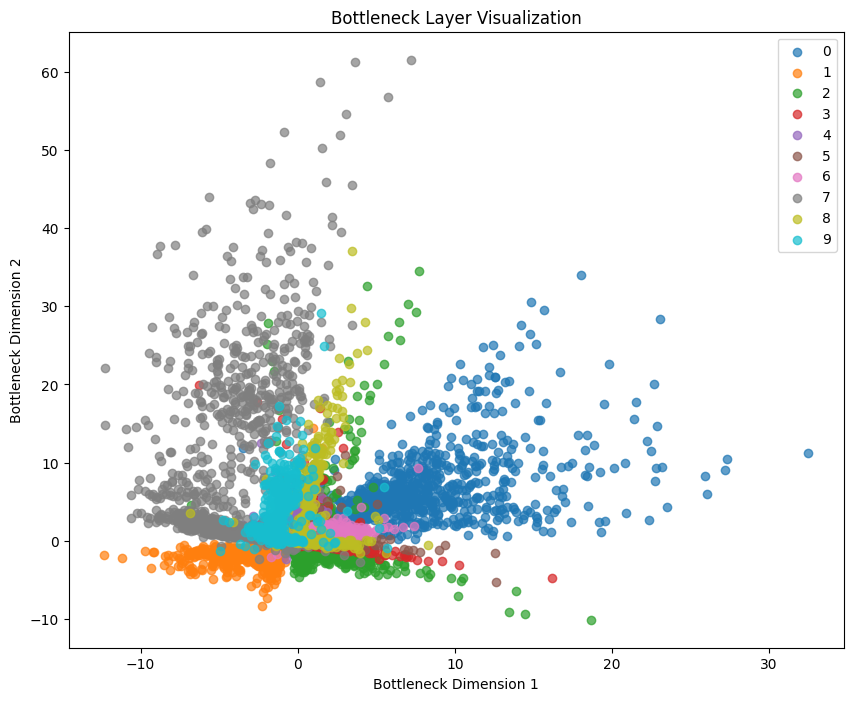

In [92]:
experiment = AutoencoderExperiment(encoding_dim=2, batch_size=128, learning_rate=0.001, num_epochs=30)
experiment.load_data()
experiment.train_autoencoder()
experiment.visualize_bottleneck()

### Representation Quality:

- The PCA model effectively separates digits with distinct linear features. We can see this in the diagram above with numbers like as 0, 1, and 7 where there is good separation.
- On the other hand, numbers with curved elements or complex structures, like 3, 5, and 8, are less nicely separated in PCA due to its linear approach. One element of reasoning here is how similar they appear, like 3 and 8 are very similar for example.
- The t-SNE model is quite robust at preserving local structures and producing distinct clusters for most digits. We can see this with even the challenging ones like 3 and 5 and 8. 
- That said t-SNE occasionally produces overlaps at cluster boundaries for visually similar digits due to sensitivity to hyperparameters. I modified the perplexity and number of iterations to demonstrate this above.
- The two autoencoders I created handled non-linear relationships better than PCA, separating digits like 0, 1, and 7 into tighter clusters. I created two Autoencoders to test out different architectures and explore it a little more.
- One observation I made is that autoencoders struggle with certain digits, like 3, 5, and 8, due to latent space expressiveness limitations. This was slightly similar to what I saw with PCA.
- With the Autoencoders, I tested out different dimensions, batch sizes, epochs, and learning rates to see the differences of modifying these settings.

### Technique Comparison:

- First, PCA is computationally efficient and scales well for large datasets which generally makes it suitable for quick analysis. It is also well suited for product level environments where fast and efficient computation is preferred.
- PCA however fails to capture non-linear patterns which leads to poor clustering for digits with subtle or complex variations. it does however excel at linear patterns given the orthogonal transformation process it conducts.
- Second, t-SNE provides excellent cluster separations but is computationally expensive and struggles with scalability for large datasets. This is less optimal for product level environments, but can still be used when accuracy and good separation is key.
- That said, t-SNE is highly sensitive to hyperparameters like perplexity and learning rate requiring careful tuning for optimal results. I demonstrated this above with many examples.
- Autoencoders offer flexibility in capturing non-linear relationships, making them more effective for complex datasets like MNIST and many others.
- Autoencoders require more training and tuning, making them computationally intensive and less scalable for rapid deployment. They can however be saved as PKL files and loaded to be reused elsewhere.

### Interpretation:

- One item I noticed is that PCA captures global variance but has trouble in separating digits with similar overall structures, such as 4 and 9, or 3 and 8. This is because it is a linear model that uses orthogonal transformation.
- PCA works best for digits with unique structural features, like 1 (which has a vertical line) and 0 (which has more circular shape).
- What we can see with t-SNE is that it preserves local structures effectively and is creating distinct and interpretable clusters for most digits. This model is non-linear and capture and separate those features better, and can handle items like 3 vs 8 and 4 vs 9 where PCA had some trouble.
- One item worth noting is t-SNE’s lack of global structure preservation may lead to misinterpretation of inter-cluster distances. This is because of the inherit nature of the model.
- One interest item about Autoencoders is that it can learn latent representations tailored to the reconstruction task, providing moderate separability for most digits. While I found that t-SNE did a better job overall, it still was not too bad.
- When it comes to the Autoencoder performance, it heavily depends on architecture and training with potential improvements for challenging digits through enhanced designs and architectures. I tested a few out to explore above, changing a few parameters to explore the differences.

## Conclusion:

- PCA is a fast and computationally efficient linear model/technique that works well for separating digits with distinct linear features, such as 0 and 1, but struggles with non-linear patterns and overlapping clusters like 3 and 5 and 8.
- The t-SNE model provides the most visually distinct clusters by preserving local structures making it ideal for exploratory analysis, but it is computationally intensive and lacks scalability for larger datasets. It does however change its shape given the stochastic nature of the model.
- Autoencoders however offer flexibility in capturing non-linear relationships and perform well on digits with unique features, such as 0, 1, and 7, but require careful tuning of architecture and hyperparameters to improve performance for overlapping digits like 3, 5, and 8. I demonstrated this above in the code with changing the parameters and architecture.
- While PCA leads when it comes to speed and simplicity, it is unsuitable for datasets with high non-linear complexity, where t-SNE and Autoencoders significantly outperform it. 
- THat said, t-SNE is the most effective for visualizing separability in the MNIST dataset, while Autoencoders provide a balance between scalability and non-linear pattern learning making them adaptable to more complex tasks.
- It is important to note that these observations are based on the MNIST dataset, which has both linear and non-linear nature in the data.